<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention2_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:11<00:00,  8.95it/s]


epoch: 0, lossD:1.3194844034834974, lossG:20.570858566506395,lossG_fake:14.89397921145541, lossG_real:5.676879283293937 ,equality:9.217099928161472


evaluate:218.75518798828125,kid_mean:0.18426117300987244, kid_std:0.026013853028416634,kid_:(tensor(0.1843), tensor(0.0260))


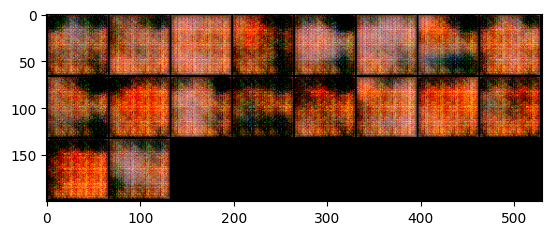

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 1, lossD:0.7527155536543397, lossG:9.465060025742911,lossG_fake:5.416868103939352, lossG_real:4.048191922960929 ,equality:1.3686761809784231


evaluate:150.69332885742188,kid_mean:0.10816679894924164, kid_std:0.03919408470392227,kid_:(tensor(0.1082), tensor(0.0392))


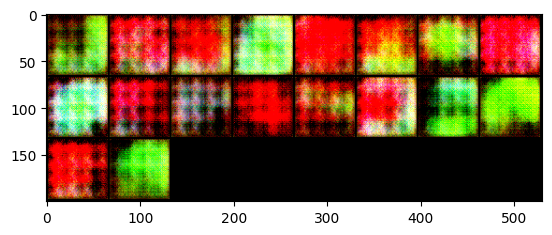

100%|██████████| 103/103 [00:09<00:00, 10.75it/s]


epoch: 2, lossD:1.071238132645783, lossG:7.203767382982865,lossG_fake:4.1537429071167145, lossG_real:3.050024461109661 ,equality:1.1037184460070533


evaluate:138.12789916992188,kid_mean:0.08924368023872375, kid_std:0.03455245867371559,kid_:(tensor(0.0892), tensor(0.0346))


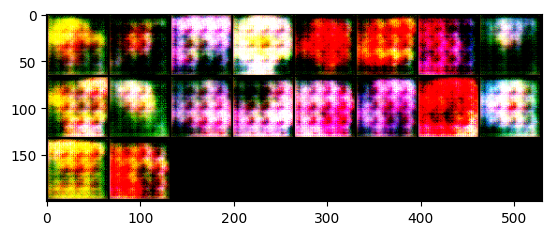

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 3, lossD:1.1886869214692162, lossG:7.346885769112596,lossG_fake:4.481135840554839, lossG_real:2.8657499181414114 ,equality:1.6153859224134277


evaluate:145.34852600097656,kid_mean:0.10171787440776825, kid_std:0.04004839062690735,kid_:(tensor(0.1017), tensor(0.0400))


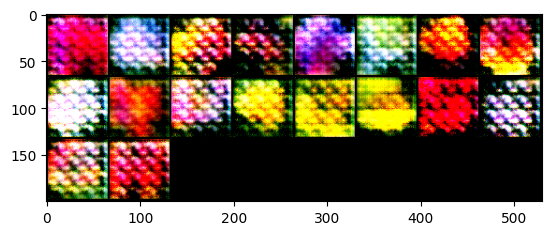

100%|██████████| 103/103 [00:09<00:00, 10.49it/s]


epoch: 4, lossD:0.9693078032685715, lossG:6.849288491369451,lossG_fake:4.001908880993001, lossG_real:2.847379635838629 ,equality:1.1545292451543716


evaluate:141.68138122558594,kid_mean:0.10595479607582092, kid_std:0.04974369704723358,kid_:(tensor(0.1060), tensor(0.0497))


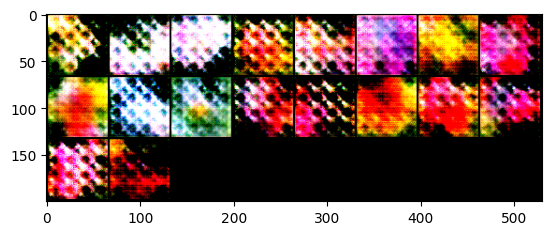

100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


epoch: 5, lossD:1.0186965018510818, lossG:6.877681222934167,lossG_fake:4.021193255498571, lossG_real:2.856487968014282 ,equality:1.164705287484289


evaluate:134.28305053710938,kid_mean:0.08950239419937134, kid_std:0.04230981320142746,kid_:(tensor(0.0895), tensor(0.0423))


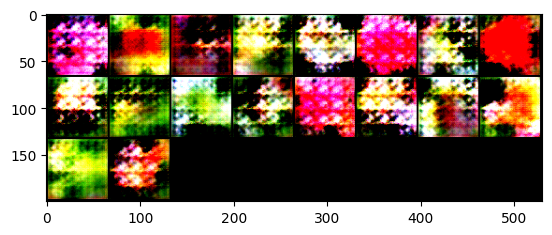

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 6, lossD:1.1154881455365895, lossG:6.609089680088377,lossG_fake:3.8603269706652004, lossG_real:2.7487627079764616 ,equality:1.1115642626887388


evaluate:133.25526428222656,kid_mean:0.09190797805786133, kid_std:0.03964883089065552,kid_:(tensor(0.0919), tensor(0.0396))


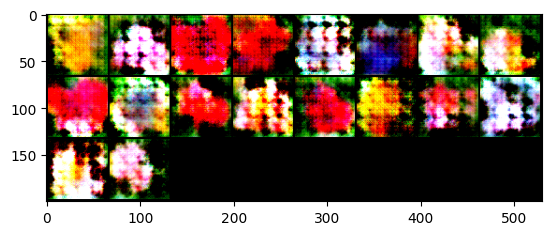

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 7, lossD:0.929158289745016, lossG:6.935682306011904,lossG_fake:4.036267561819947, lossG_real:2.8994147412985276 ,equality:1.136852820521419


evaluate:130.76998901367188,kid_mean:0.08289072662591934, kid_std:0.039379313588142395,kid_:(tensor(0.0829), tensor(0.0394))


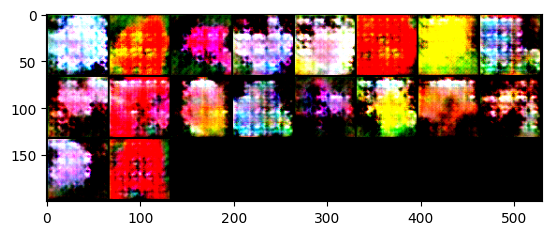

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 8, lossD:0.9907651231126878, lossG:6.874560374658085,lossG_fake:4.0145240883225375, lossG_real:2.8600362574012532 ,equality:1.1544878309212843


evaluate:134.0948486328125,kid_mean:0.08020279556512833, kid_std:0.0392899364233017,kid_:(tensor(0.0802), tensor(0.0393))


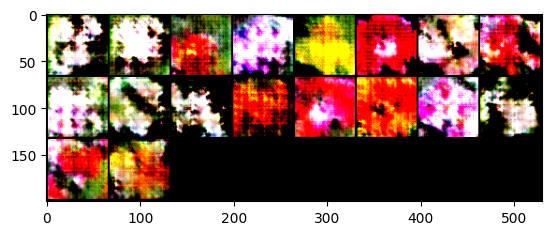

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 9, lossD:1.01157086277471, lossG:6.465244788567997,lossG_fake:3.65265822757795, lossG_real:2.812586558964646 ,equality:0.8400716686133038


evaluate:134.42474365234375,kid_mean:0.08071354031562805, kid_std:0.04649655893445015,kid_:(tensor(0.0807), tensor(0.0465))


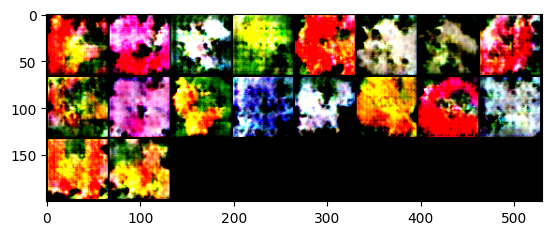

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 10, lossD:1.063569097842985, lossG:6.333019478807172,lossG_fake:3.5744887717719216, lossG_real:2.758530728446627 ,equality:0.8159580433252946


evaluate:141.77694702148438,kid_mean:0.0981871709227562, kid_std:0.045783866196870804,kid_:(tensor(0.0982), tensor(0.0458))


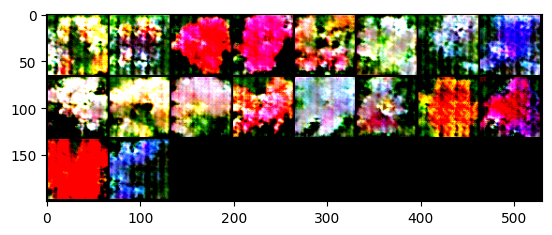

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 11, lossD:0.9464624816352881, lossG:6.397074884581334,lossG_fake:3.5322095283026833, lossG_real:2.8648653892637457 ,equality:0.6673441390389376


evaluate:141.0756378173828,kid_mean:0.09267663955688477, kid_std:0.04950299113988876,kid_:(tensor(0.0927), tensor(0.0495))


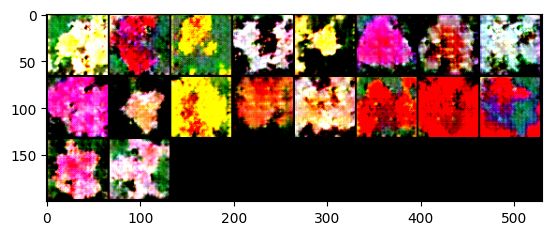

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 12, lossD:0.9091293617938329, lossG:6.499275351033627,lossG_fake:3.5638093774758497, lossG_real:2.935465977029893 ,equality:0.6283434004459565


evaluate:137.66351318359375,kid_mean:0.09213761985301971, kid_std:0.04752872884273529,kid_:(tensor(0.0921), tensor(0.0475))


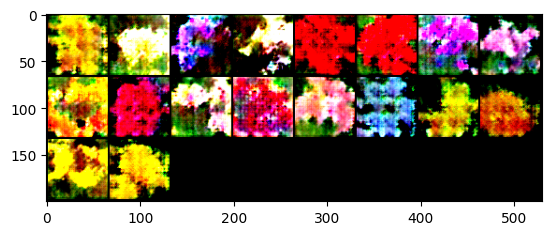

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 13, lossD:0.964546810799432, lossG:6.540016859480478,lossG_fake:3.6056122056488853, lossG_real:2.9344046607758236 ,equality:0.6712075448730617


evaluate:133.3609619140625,kid_mean:0.0861859992146492, kid_std:0.044972021132707596,kid_:(tensor(0.0862), tensor(0.0450))


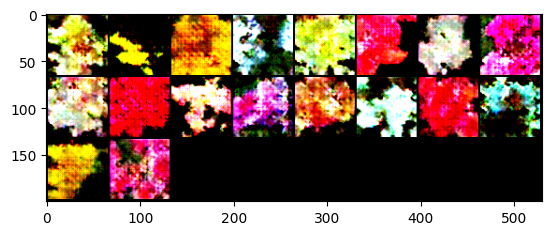

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 14, lossD:0.9681754944104592, lossG:6.413014462850626,lossG_fake:3.582392139342225, lossG_real:2.83062231251337 ,equality:0.7517698268288551


evaluate:134.79257202148438,kid_mean:0.08679288625717163, kid_std:0.049098558723926544,kid_:(tensor(0.0868), tensor(0.0491))


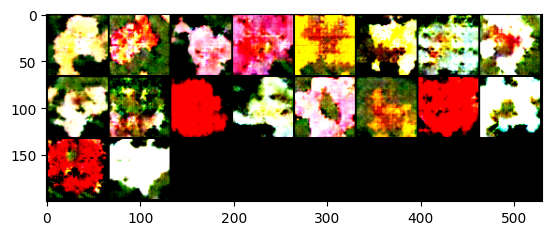

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 15, lossD:0.8671339546303147, lossG:6.71880276226303,lossG_fake:3.678918866856584, lossG_real:3.0398838844114136 ,equality:0.6390349824451707


evaluate:132.27047729492188,kid_mean:0.1020096018910408, kid_std:0.04890362173318863,kid_:(tensor(0.1020), tensor(0.0489))


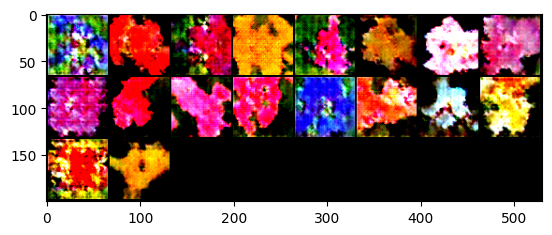

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 16, lossD:0.7434752409897961, lossG:7.033779542422989,lossG_fake:3.873889571254693, lossG_real:3.1598899925796733 ,equality:0.7139995786750197


evaluate:131.3667449951172,kid_mean:0.09054037183523178, kid_std:0.04513013735413551,kid_:(tensor(0.0905), tensor(0.0451))


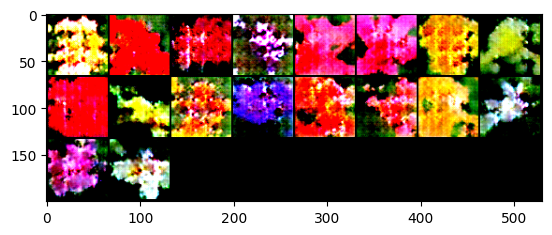

100%|██████████| 103/103 [00:10<00:00, 10.30it/s]


epoch: 17, lossD:0.6445113693192167, lossG:7.30038954447774,lossG_fake:3.9662771444876217, lossG_real:3.3341123889950874 ,equality:0.6321647554925343


evaluate:132.27835083007812,kid_mean:0.09546100348234177, kid_std:0.048534736037254333,kid_:(tensor(0.0955), tensor(0.0485))


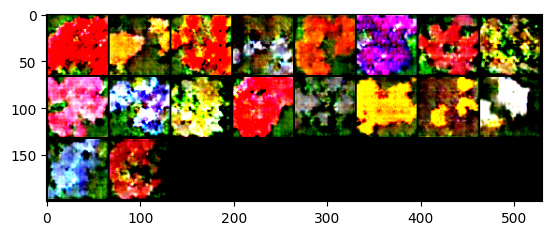

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 18, lossD:0.6181264731635168, lossG:7.714423619427727,lossG_fake:4.159384147634784, lossG_real:3.555039468320828 ,equality:0.6043446793139555


evaluate:133.63270568847656,kid_mean:0.08723911643028259, kid_std:0.0452713742852211,kid_:(tensor(0.0872), tensor(0.0453))


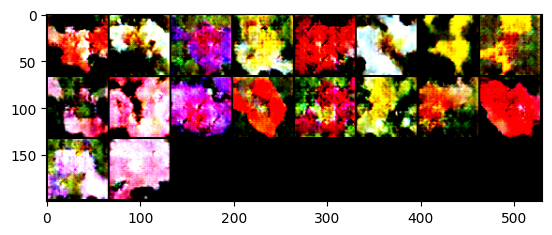

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 19, lossD:0.5876060035079718, lossG:8.030009269714355,lossG_fake:4.416309952735901, lossG_real:3.6136993250800566 ,equality:0.8026106276558442


evaluate:134.03396606445312,kid_mean:0.08569857478141785, kid_std:0.04328571632504463,kid_:(tensor(0.0857), tensor(0.0433))


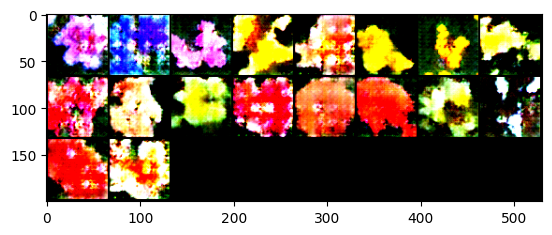

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 20, lossD:0.5072430634816874, lossG:8.306711821880155,lossG_fake:4.5938014035086026, lossG_real:3.712910396092146 ,equality:0.8808910074164564


evaluate:135.13365173339844,kid_mean:0.09955991059541702, kid_std:0.05252956226468086,kid_:(tensor(0.0996), tensor(0.0525))


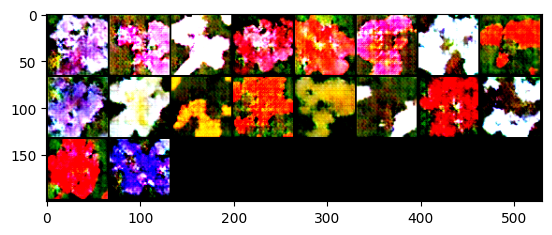

100%|██████████| 103/103 [00:09<00:00, 10.30it/s]


epoch: 21, lossD:0.4617763551548847, lossG:8.317976655311956,lossG_fake:4.502131878750996, lossG_real:3.8158447522561527 ,equality:0.6862871264948431


evaluate:131.78707885742188,kid_mean:0.08619026094675064, kid_std:0.044079236686229706,kid_:(tensor(0.0862), tensor(0.0441))


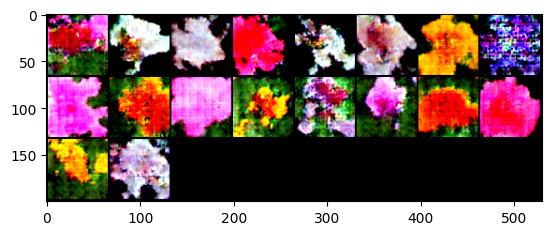

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 22, lossD:0.5252168698652276, lossG:8.399565729122717,lossG_fake:4.517758124082992, lossG_real:3.881807625004389 ,equality:0.6359504990786027


evaluate:131.9666290283203,kid_mean:0.08836981654167175, kid_std:0.04795953631401062,kid_:(tensor(0.0884), tensor(0.0480))


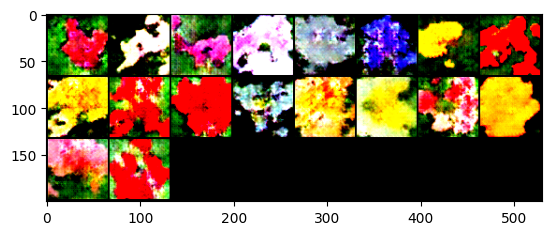

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 23, lossD:0.4704818051959415, lossG:8.454269265665591,lossG_fake:4.577224217572258, lossG_real:3.8770450596670503 ,equality:0.7001791579052079


evaluate:132.45248413085938,kid_mean:0.09789169579744339, kid_std:0.0476459376513958,kid_:(tensor(0.0979), tensor(0.0476))


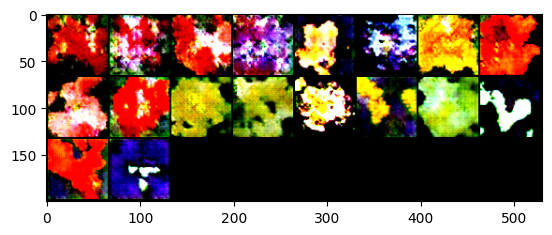

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 24, lossD:0.31215208096122277, lossG:8.315455714475762,lossG_fake:4.397927578213145, lossG_real:3.9175281744558834 ,equality:0.48039940375726164


evaluate:133.7559051513672,kid_mean:0.08972690254449844, kid_std:0.04418203607201576,kid_:(tensor(0.0897), tensor(0.0442))


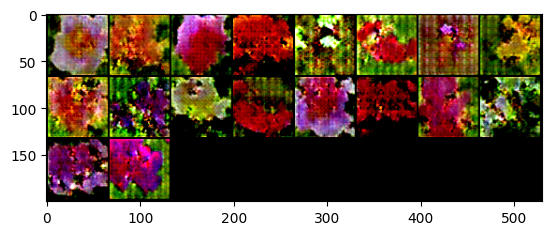

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 25, lossD:0.3510882548843194, lossG:9.235853834059633,lossG_fake:5.0005299420032685, lossG_real:4.235323878167902 ,equality:0.7652060638353664


evaluate:132.11892700195312,kid_mean:0.09055664390325546, kid_std:0.051899503916502,kid_:(tensor(0.0906), tensor(0.0519))


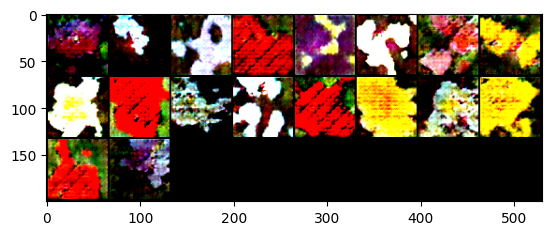

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 26, lossD:0.35768354212123793, lossG:8.891539772737373,lossG_fake:4.650320048471099, lossG_real:4.241219731210505 ,equality:0.40910031726059426


evaluate:129.2613525390625,kid_mean:0.08560247719287872, kid_std:0.042802970856428146,kid_:(tensor(0.0856), tensor(0.0428))


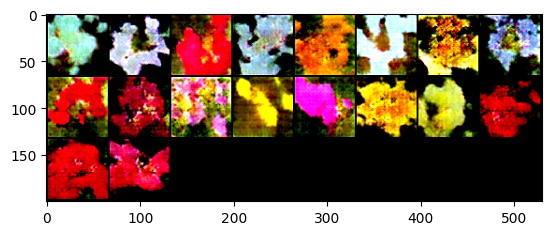

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 27, lossD:0.33297098755330135, lossG:9.038789559336541,lossG_fake:4.857559031653173, lossG_real:4.181230532312856 ,equality:0.6763284993403165


evaluate:129.79684448242188,kid_mean:0.08585997670888901, kid_std:0.03919356316328049,kid_:(tensor(0.0859), tensor(0.0392))


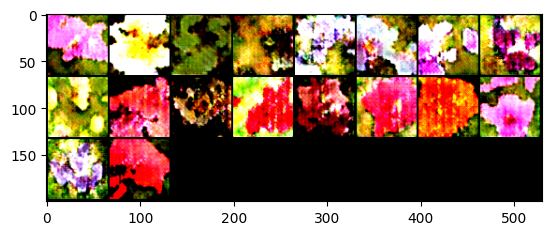

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 28, lossD:0.32627739174996767, lossG:9.447359622103496,lossG_fake:5.012526204285113, lossG_real:4.43483338975212 ,equality:0.5776928145329929


evaluate:131.08486938476562,kid_mean:0.0911017432808876, kid_std:0.04352647066116333,kid_:(tensor(0.0911), tensor(0.0435))


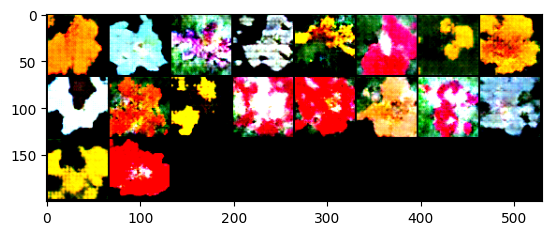

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 29, lossD:0.3144905455229641, lossG:9.741040822371696,lossG_fake:5.271094741173161, lossG_real:4.469946099137797 ,equality:0.801148642035364


evaluate:130.5354461669922,kid_mean:0.09392619878053665, kid_std:0.04439407214522362,kid_:(tensor(0.0939), tensor(0.0444))


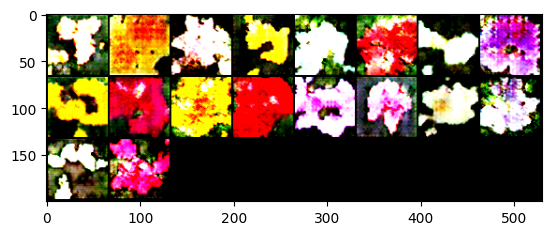

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 30, lossD:0.3918010645808236, lossG:9.591357985746514,lossG_fake:5.112916381613722, lossG_real:4.478441603264763 ,equality:0.6344747783489595


evaluate:130.34950256347656,kid_mean:0.07798103988170624, kid_std:0.04042799770832062,kid_:(tensor(0.0780), tensor(0.0404))


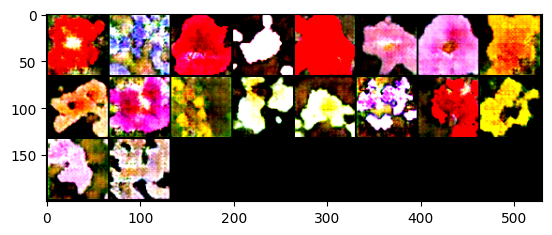

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 31, lossD:0.2427304065560253, lossG:9.431539929028853,lossG_fake:4.932205955959061, lossG_real:4.499333988115626 ,equality:0.4328719678434352


evaluate:129.7333984375,kid_mean:0.09267111122608185, kid_std:0.046068593859672546,kid_:(tensor(0.0927), tensor(0.0461))


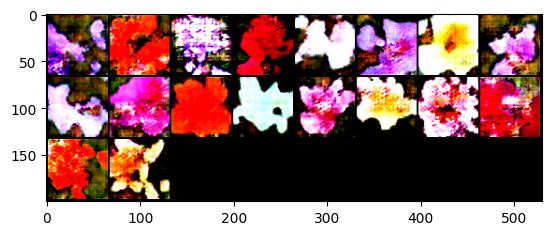

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 32, lossD:0.2642543688235642, lossG:9.74983942161486,lossG_fake:5.256846814479642, lossG_real:4.492992594404128 ,equality:0.7638542200755145


evaluate:128.3899383544922,kid_mean:0.08872785419225693, kid_std:0.04163229838013649,kid_:(tensor(0.0887), tensor(0.0416))


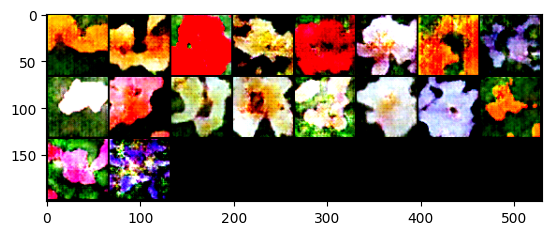

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 33, lossD:0.32376754233270016, lossG:9.674539325306716,lossG_fake:5.133459092922581, lossG_real:4.5410802306480775 ,equality:0.5923788622745034


evaluate:127.73688507080078,kid_mean:0.09086059778928757, kid_std:0.04402793571352959,kid_:(tensor(0.0909), tensor(0.0440))


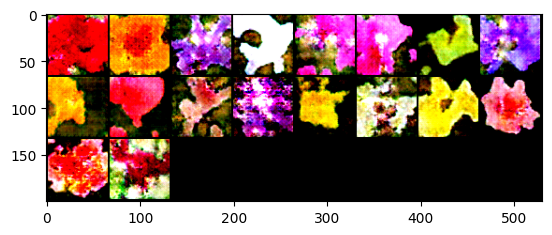

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 34, lossD:0.23937457751084878, lossG:10.038295282900911,lossG_fake:5.2822249468090465, lossG_real:4.75607032567552 ,equality:0.5261546211335268


evaluate:126.1395034790039,kid_mean:0.08468914777040482, kid_std:0.05118979513645172,kid_:(tensor(0.0847), tensor(0.0512))


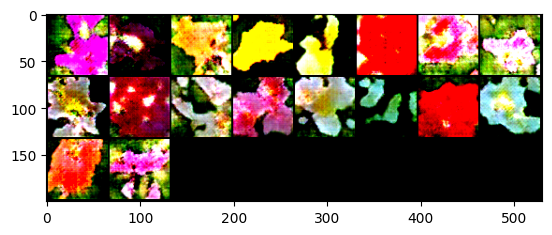

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 35, lossD:0.2651758513151153, lossG:9.859698823354776,lossG_fake:5.14560875036184, lossG_real:4.714090077622423 ,equality:0.4315186727394176


evaluate:126.89627838134766,kid_mean:0.08070438355207443, kid_std:0.04383448138833046,kid_:(tensor(0.0807), tensor(0.0438))


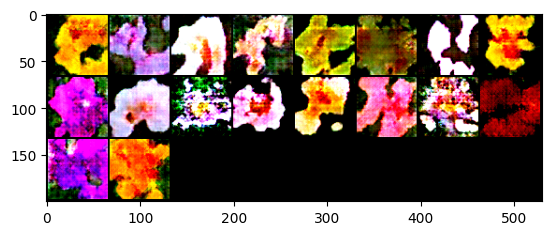

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 36, lossD:0.22364385981221221, lossG:10.235581536894863,lossG_fake:5.389754323126043, lossG_real:4.845827237494941 ,equality:0.5439270856311023


evaluate:126.7857437133789,kid_mean:0.09457183629274368, kid_std:0.05050663650035858,kid_:(tensor(0.0946), tensor(0.0505))


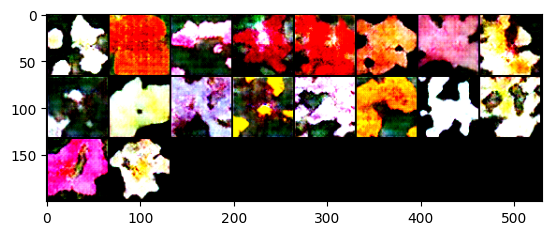

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 37, lossD:0.319967134484967, lossG:10.391363393913196,lossG_fake:5.580094077054737, lossG_real:4.811269320330574 ,equality:0.7688247567241628


evaluate:121.28434753417969,kid_mean:0.08393535017967224, kid_std:0.04183763638138771,kid_:(tensor(0.0839), tensor(0.0418))


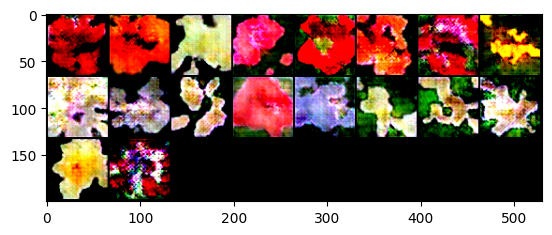

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 38, lossD:0.2364126279118281, lossG:10.246442702210064,lossG_fake:5.491989452862045, lossG_real:4.754453274810198 ,equality:0.7375361780518466


evaluate:115.7706527709961,kid_mean:0.07505270838737488, kid_std:0.03942414000630379,kid_:(tensor(0.0751), tensor(0.0394))


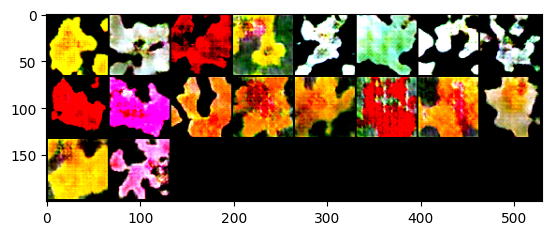

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 39, lossD:0.2260131929205387, lossG:10.037247667034853,lossG_fake:5.265648119657943, lossG_real:4.771599574575147 ,equality:0.49404854508279605


evaluate:113.2107162475586,kid_mean:0.08269184827804565, kid_std:0.04257567599415779,kid_:(tensor(0.0827), tensor(0.0426))


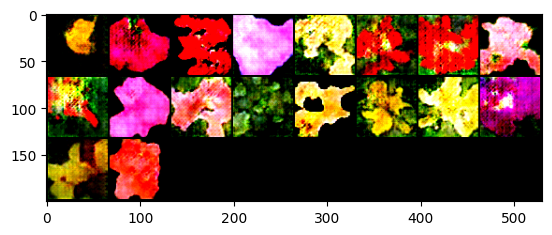

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 40, lossD:0.20386448576684715, lossG:10.54150104522705,lossG_fake:5.587440055550881, lossG_real:4.9540609919909135 ,equality:0.6333790635599676


evaluate:111.86465454101562,kid_mean:0.08308090269565582, kid_std:0.03747090324759483,kid_:(tensor(0.0831), tensor(0.0375))


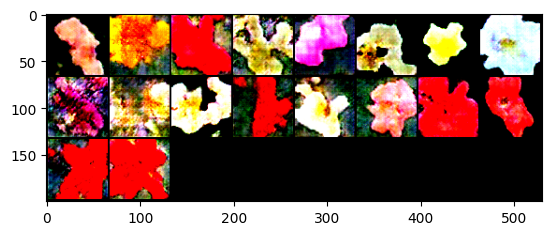

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 41, lossD:0.2322343127096741, lossG:10.630767137101554,lossG_fake:5.583750157680326, lossG_real:5.047016963218022 ,equality:0.5367331944623039


evaluate:112.6037368774414,kid_mean:0.0793958306312561, kid_std:0.042451076209545135,kid_:(tensor(0.0794), tensor(0.0425))


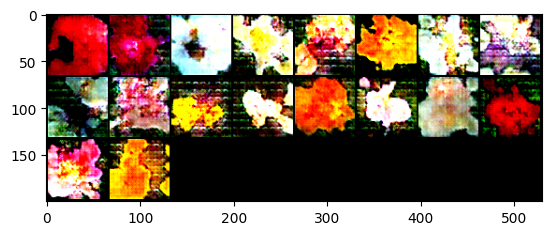

100%|██████████| 103/103 [00:09<00:00, 10.32it/s]


epoch: 42, lossD:0.16668464364574373, lossG:10.805324934061291,lossG_fake:5.797890458292174, lossG_real:5.007434469982258 ,equality:0.7904559883099154


evaluate:103.42755126953125,kid_mean:0.07853512465953827, kid_std:0.043852925300598145,kid_:(tensor(0.0785), tensor(0.0439))


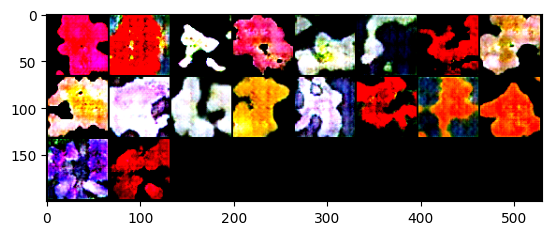

100%|██████████| 103/103 [00:10<00:00, 10.24it/s]


epoch: 43, lossD:0.11337384851016466, lossG:11.46282229377228,lossG_fake:5.824986548099703, lossG_real:5.637835759561039 ,equality:0.18715078853866451


evaluate:104.40092468261719,kid_mean:0.08318211883306503, kid_std:0.04001666232943535,kid_:(tensor(0.0832), tensor(0.0400))


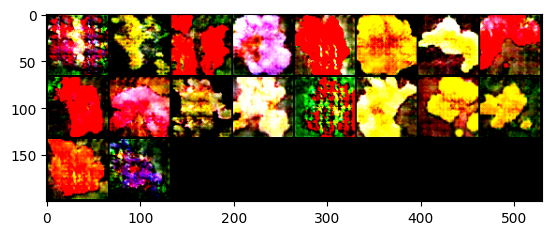

100%|██████████| 103/103 [00:10<00:00, 10.22it/s]


epoch: 44, lossD:0.24166132746607932, lossG:11.274182625187253,lossG_fake:5.942024175403188, lossG_real:5.332158454413553 ,equality:0.6098657209896352


evaluate:100.54744720458984,kid_mean:0.07754592597484589, kid_std:0.04091040790081024,kid_:(tensor(0.0775), tensor(0.0409))


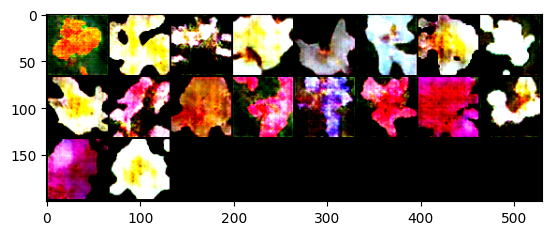

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 45, lossD:0.2056503313982371, lossG:11.038359197598059,lossG_fake:5.782912484650473, lossG_real:5.255446745353995 ,equality:0.5274657392964786


evaluate:99.4274673461914,kid_mean:0.07830227166414261, kid_std:0.043334655463695526,kid_:(tensor(0.0783), tensor(0.0433))


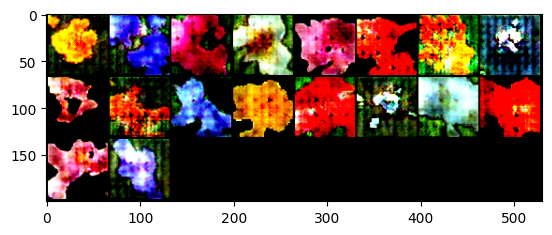

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 46, lossD:0.24163900628613616, lossG:11.302589842416708,lossG_fake:5.907313486904774, lossG_real:5.395276367085652 ,equality:0.512037119819122


evaluate:97.62378692626953,kid_mean:0.07839077711105347, kid_std:0.04360595718026161,kid_:(tensor(0.0784), tensor(0.0436))


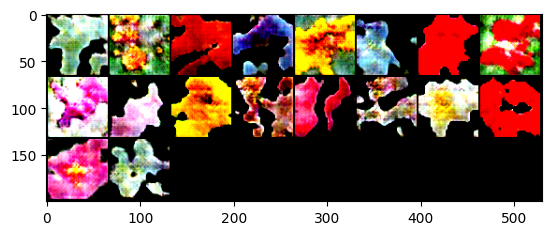

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 47, lossD:0.09214339119572083, lossG:11.11126725650528,lossG_fake:5.802126254850221, lossG_real:5.3091410224877515 ,equality:0.4929852323624697


evaluate:98.30364990234375,kid_mean:0.08386408537626266, kid_std:0.04731576517224312,kid_:(tensor(0.0839), tensor(0.0473))


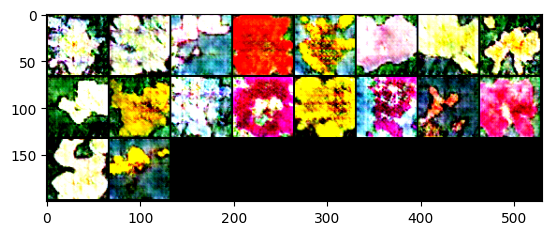

100%|██████████| 103/103 [00:09<00:00, 10.33it/s]


epoch: 48, lossD:0.22030170379405462, lossG:11.506061044711512,lossG_fake:6.138525715152037, lossG_real:5.367535324929987 ,equality:0.7709903902220496


evaluate:97.35215759277344,kid_mean:0.0788177028298378, kid_std:0.040017757564783096,kid_:(tensor(0.0788), tensor(0.0400))


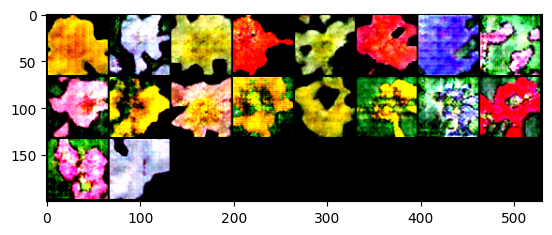

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 49, lossD:0.1804447087811903, lossG:11.590545895030198,lossG_fake:6.238695591398813, lossG_real:5.351850315205102 ,equality:0.8868452761937116


evaluate:97.59545135498047,kid_mean:0.07744277268648148, kid_std:0.053640954196453094,kid_:(tensor(0.0774), tensor(0.0536))


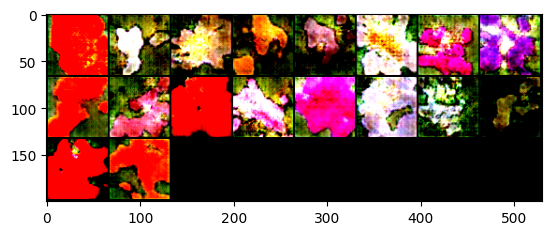

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

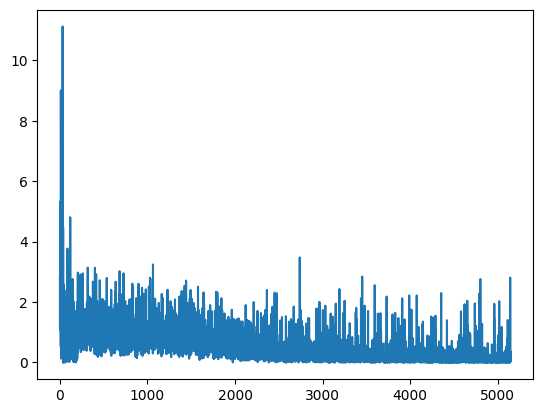

In [45]:
plt.plot(raw_lossesD)

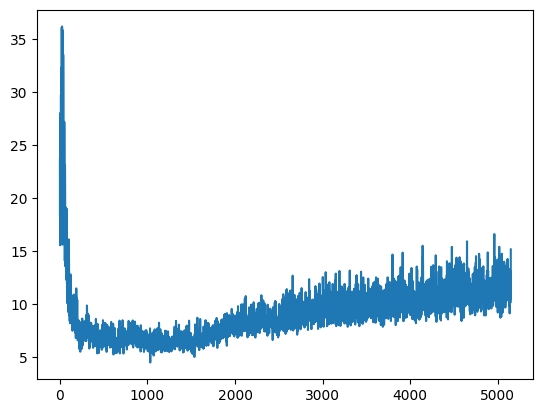

In [46]:
plt.plot(raw_lossesG)

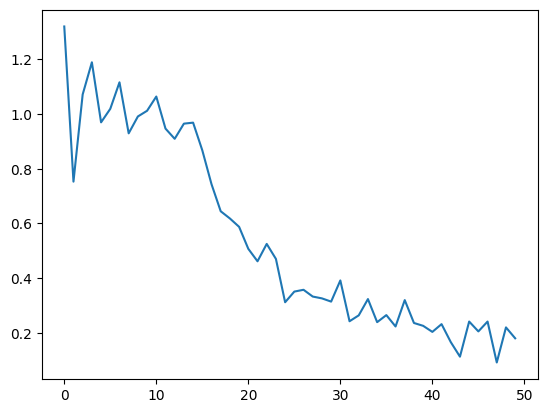

In [47]:
plt.plot(lossesD)

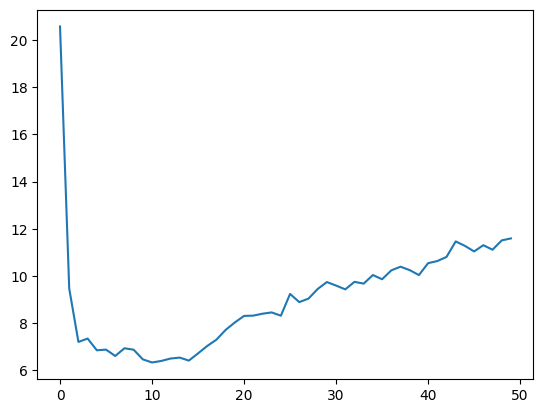

In [48]:
plt.plot(lossesG)

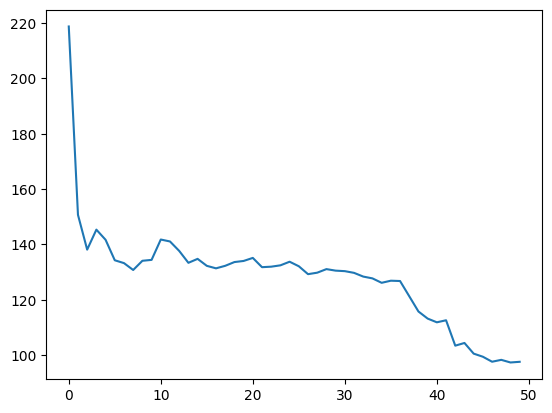

In [49]:
plt.plot(fid_)

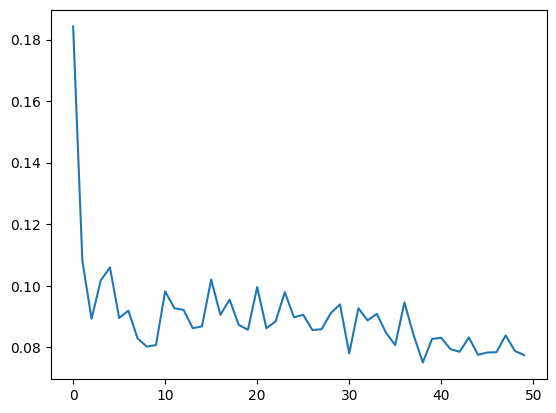

In [50]:
plt.plot(kid_mean_)

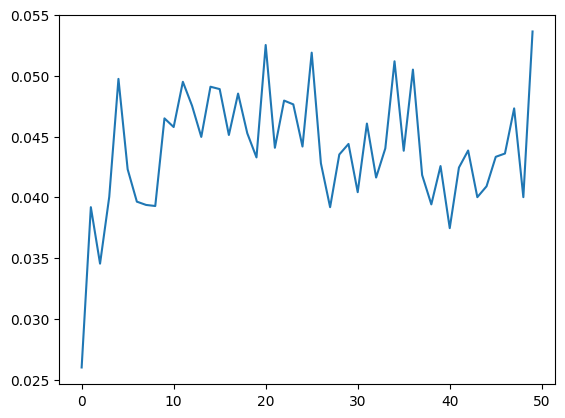

In [51]:
plt.plot(kid_std_)

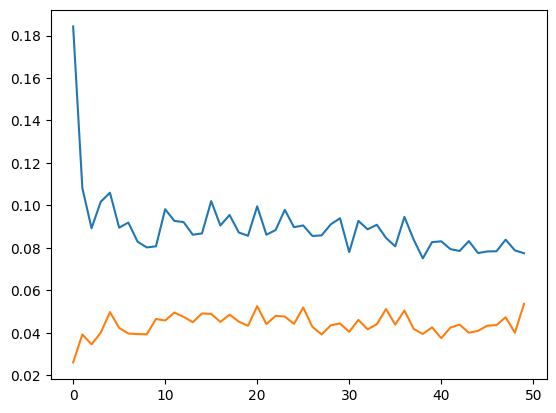

In [52]:
plt.plot(kid_score)

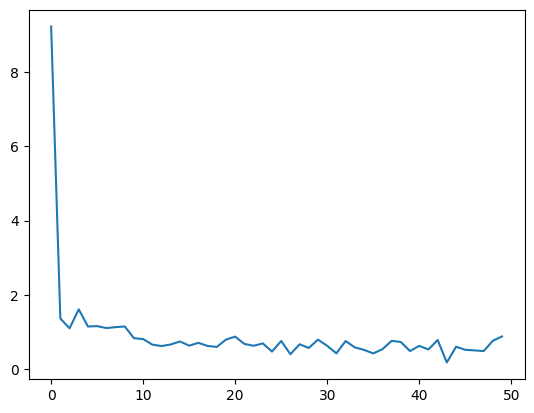

In [53]:
plt.plot(d_equality)

In [54]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

fid  tensor(97.8358)
kid  (tensor(0.0779), tensor(0.0370))
PSNR tensor(71.4669)
SSIM値: 0.9796053362381829
